### Importando as bibliotecas necessarias

In [37]:
import os
import tempfile
import pandas as pd

import numpy as np
import tensorflow as tf

import tensorflow_recommenders as tfrs

In [38]:
anime_syn = pd.read_csv('anime_with_synopsis.csv')
animelist = pd.read_csv('animelist.csv', nrows=1000000)

### Data Exploration and Visualization
Aqui utilizaremos duas fontes de dados:

*anime_with_synopsis.csv* - Contém o id, nome, score, genero e sinopse de todos os animes.

*animelist* - Contém user_id, anime_id, watching_status, watched_episodes

A base de dados contém 16214 animes.

In [39]:
print(anime_syn.shape)
anime_syn.head()

(16214, 5)


,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


A base de dados completa contém mais de 100 milhões de interações de usuarios, mas para esse teste eu utilizarei somente 10000 interações pra entendermos como o modelo se comporta com poucos dados.

In [40]:
al = animelist.sample(frac=1).iloc[:10000]
animelist.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


Pegamos uma amostra aleatoria de usuarios contendo diferentes quantidades de interações, para ver como o modelo se comporta em cada caso

In [41]:
al.user_id.value_counts()

3160    36
781     35
890     32
3021    31
1397    31
        ..
1204     1
1302     1
1906     1
2134     1
2080     1
Name: user_id, Length: 2342, dtype: int64

### Data Preprocessing
Aqui será unificado a tabela de sinopses com a tabela de interações ja que precisa ser fornecido somente uma tabela para o modelo.
Tambem será filtrado somente as colunas que serão usadas para treino.

In [53]:

interactions = al.merge(anime_syn, left_on='anime_id',right_on='MAL_ID')
dataset = interactions[["user_id","anime_id","Name","sypnopsis","Genres"]]

In [54]:
dataset = tf.data.Dataset.from_tensor_slices(dataset.astype(str).to_dict(orient='list'))
animes_data = tf.data.Dataset.from_tensor_slices(anime_syn.astype(str))

In [ ]:
unique_anime_titles = np.unique(list(dataset.map(lambda x: x["anime_id"]).as_numpy_iterator()))
unique_user_ids = np.unique(list(dataset.map(lambda x: x["user_id"]).as_numpy_iterator()))

In [ ]:
print(f"Quantidade de animes na no dataset: {len(unique_anime_titles)}")
print(f"Quantidade de usuarios na no dataset: {len(unique_user_ids)}")

In [ ]:
animes = dataset.map(lambda x: {
    "anime_id": x["anime_id"],
    "sypnopsis": x["sypnopsis"],
    "names": x["Name"],
    "genres": x["Genres"]
})

### Modeling

In [47]:
class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

  def call(self, inputs):
    return self.user_embedding(inputs["user_id"])

In [48]:
class QueryModel(tf.keras.Model):

  def __init__(self, layer_sizes):
    super().__init__()

    self.embedding_model = UserModel()

    self.dense_layers = tf.keras.Sequential()

    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [74]:
class animeModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000
  # Uma camada de pré-processamento que mapeia recursos de string para índices inteiros.
    self.anime_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_anime_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_anime_titles) + 1, 32)
    ])

  # Vectorização e embedding das sinopses dos animes
    self.syp_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.syp_text_embedding = tf.keras.Sequential([
      self.syp_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.syp_vectorizer.adapt(animes.map(lambda x: x["sypnopsis"]))

    # Vectorização e embedding dos generos dos animes
    self.genre_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)
    
    self.genre_text_embedding = tf.keras.Sequential([
      self.genre_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.genre_vectorizer.adapt(animes.map(lambda x: x["genres"]))
  # Vectorização e embedding dos titulos de animes
    self.name_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)
    
    self.name_text_embedding = tf.keras.Sequential([
      self.name_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.name_vectorizer.adapt(animes.map(lambda x: x["names"]))

  def call(self, input):
    return tf.concat([
      self.anime_embedding(input["anime_id"]),
      self.syp_text_embedding(input["sypnopsis"]),
      self.genre_text_embedding(input["genres"]),
      self.name_text_embedding(input["names"])
      ],axis=1)
        

In [75]:
class CandidateModel(tf.keras.Model):

  def __init__(self, layer_sizes):
    super().__init__()

    self.embedding_model = animeModel()

    self.dense_layers = tf.keras.Sequential()

    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [85]:
class AnimelensModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=animes.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    query_embeddings = self.query_model({
        "user_id":features["user_id"]
    })
    anime_embeddings = self.candidate_model({
        "anime_id":features["anime_id"],
        "sypnopsis":features["sypnopsis"],
        "genres":features["Genres"],
        "names": features["Name"]
      })

    return self.task(
        query_embeddings, anime_embeddings, compute_metrics=not training)

In [86]:
shuffled = dataset.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

In [87]:
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [88]:
num_epochs = 40

model = AnimelensModel([32,64])

In [89]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [90]:
one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

In [91]:
one_layer_history.history.keys()

dict_keys(['factorized_top_k/top_1_categorical_accuracy', 'factorized_top_k/top_5_categorical_accuracy', 'factorized_top_k/top_10_categorical_accuracy', 'factorized_top_k/top_50_categorical_accuracy', 'factorized_top_k/top_100_categorical_accuracy', 'loss', 'regularization_loss', 'total_loss'])

In [99]:
accuracy = one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.00.


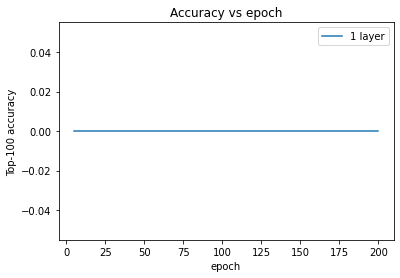

In [100]:
import matplotlib.pyplot as plt
num_validation_runs = len(one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch") 
plt.ylabel("Top-100 accuracy")
plt.legend()

### Test
Pegamos primeiro um usuario com poucas interações e testamos como a recomendação desempenha.

Primeiro vamos considerar somente o conteúdo que ele viu, podemos ver que tem atributos como:

*rating* -  um target explicito do quanto ele gostou do anime.

*watching_status* - um atributo que diz se ele abandonou, continua assistindo ou ja assistiu.

*watched_episodes* - quantidade de episódios assistidos.

Isso são atributos que poderiam ser considerados na hora do preprocessamento para melhorar a acuracia do modelo, por exemplo, poderiamos remover os animes que ele abandonou ou deu nota menor que 5.

Analisando esse usuario podemos ver que ele tem uma preferencia pelos generos:

In [147]:
print(sorted(['Action', 'Ecchi', 'Fantasy', 'Romance', 'Harem', 'Demons', 'Slice of Life', 'Comedy',  'Military', 'Sci-Fi', 'Space', 'Supernatural']))

['Action', 'Comedy', 'Demons', 'Ecchi', 'Fantasy', 'Harem', 'Military', 'Romance', 'Sci-Fi', 'Slice of Life', 'Space', 'Supernatural']


In [178]:
interactions[interactions.user_id==773].sort_values(by='rating',ascending=False).head()

,user_id,anime_id,rating,watching_status,watched_episodes,MAL_ID,Name,Score,Genres,sypnopsis
4913,773,1887,8,2,24,1887,Lucky☆Star,7.77,"Slice of Life, Comedy, Parody, School",ucky☆Star follows the daily lives of four cute...
7078,773,31953,8,2,12,31953,New Game!,7.62,"Game, Slice of Life, Comedy","Since childhood, Aoba Suzukaze has loved the F..."
7242,773,37510,8,2,13,37510,Mob Psycho 100 II,8.84,"Action, Slice of Life, Comedy, Supernatural","Shigeo ""Mob"" Kageyama is now maturing and unde..."
4606,773,34497,6,2,12,34497,Death March kara Hajimaru Isekai Kyousoukyoku,6.54,"Adventure, Fantasy, Harem","Ichirou Suzuki, a programmer nearing his thirt..."
6189,773,15417,0,1,7,15417,Gintama': Enchousen,9.04,"Action, Comedy, Historical, Parody, Samurai, S...","hile Gintoki Sakata was away, the Yorozuya fou..."


In [184]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model,15)
index.index_from_dataset(
  tf.data.Dataset.zip((animes.batch(128).map(lambda x: x["anime_id"]), animes.batch(128).map(model.candidate_model)))
)

animes_s = interactions.loc[interactions.user_id ==793,'MAL_ID'].astype(str).values

scores, titles = index.query_with_exclusions(
    queries={'user_id':np.array(["793"])},
    exclusions=tf.constant([animes_s]),
    k=15)

# scores, titles = index(
#     queries={'user_id':np.array(["793"])},
#   )

print(f"Recommendations for user 793: {titles}")

Recommendations for user 793: [[b'1138' b'1138' b'6211' b'6211' b'6211' b'6211' b'35249' b'35249'
  b'34451' b'34451' b'34451' b'34451' b'9062' b'9062' b'30091']]


In [185]:
%%time
recomendations = {"Name":[], "Genres":[]}
for title in np.unique(titles[0]):
    recomendations["Name"].append(interactions.loc[interactions.anime_id == int(title.decode('utf-8')),'Name'].values[0])
    recomendations["Genres"].append(interactions.loc[interactions.anime_id == int(title.decode('utf-8')),'Genres'].values[0])

Wall time: 10.4 ms


In [186]:
r = pd.DataFrame(recomendations)
r

,Name,Genres
0,Medarot,"Adventure, Comedy, Sci-Fi, Shounen"
1,Chaos Dragon: Sekiryuu Seneki,"Action, Fantasy, Supernatural"
2,Kekkai Sensen & Beyond,"Action, Comedy, Fantasy, Shounen, Super Power,..."
3,Uma Musume: Pretty Derby (TV),"Comedy, Slice of Life, Sports"
4,Tokyo Magnitude 8.0,Drama
5,Angel Beats! Specials,"Action, Comedy, School, Supernatural"


In [187]:
genres = []
for x in r.Genres.str.split(', '):
    genres +=x
print(f"Categorias dos animes recomendados: {sorted(np.unique(genres))}")

Categorias dos animes recomendados ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'School', 'Sci-Fi', 'Shounen', 'Slice of Life', 'Sports', 'Super Power', 'Supernatural', 'Vampire']


In [189]:
print(f"Categorias dos animes assistidos: {sorted(['Action', 'Ecchi', 'Fantasy', 'Romance', 'Harem', 'Demons', 'Slice of Life', 'Comedy',  'Military', 'Sci-Fi', 'Space', 'Supernatural'])}") 

Categorias dos animes assistidos: ['Action', 'Comedy', 'Demons', 'Ecchi', 'Fantasy', 'Harem', 'Military', 'Romance', 'Sci-Fi', 'Slice of Life', 'Space', 'Supernatural']


### Anime Embeddings

In [190]:
ds = tf.data.Dataset.from_tensor_slices(anime_syn[["Name","MAL_ID","sypnopsis","Genres"]].astype(str).to_dict(orient='list'))

In [192]:
anime_names = []
anime_embeddings = []
for i,x in enumerate(ds):
  anime_names.append(x["Name"].numpy())
  anime_embeddings.append(
      model.candidate_model(
    {
    'anime_id': np.array([x["MAL_ID"].numpy().decode('utf-8')]),
    'sypnopsis': np.array([x["sypnopsis"].numpy().decode('utf-8')]),
    'genres': np.array([x["Genres"].numpy().decode('utf-8')]),
    'names': np.array([x["Name"].numpy().decode('utf-8')])
})[0])
  if i == 200:
    break


In [193]:
from sklearn.manifold import TSNE
item_tsne = TSNE(perplexity=30).fit_transform(anime_embeddings)

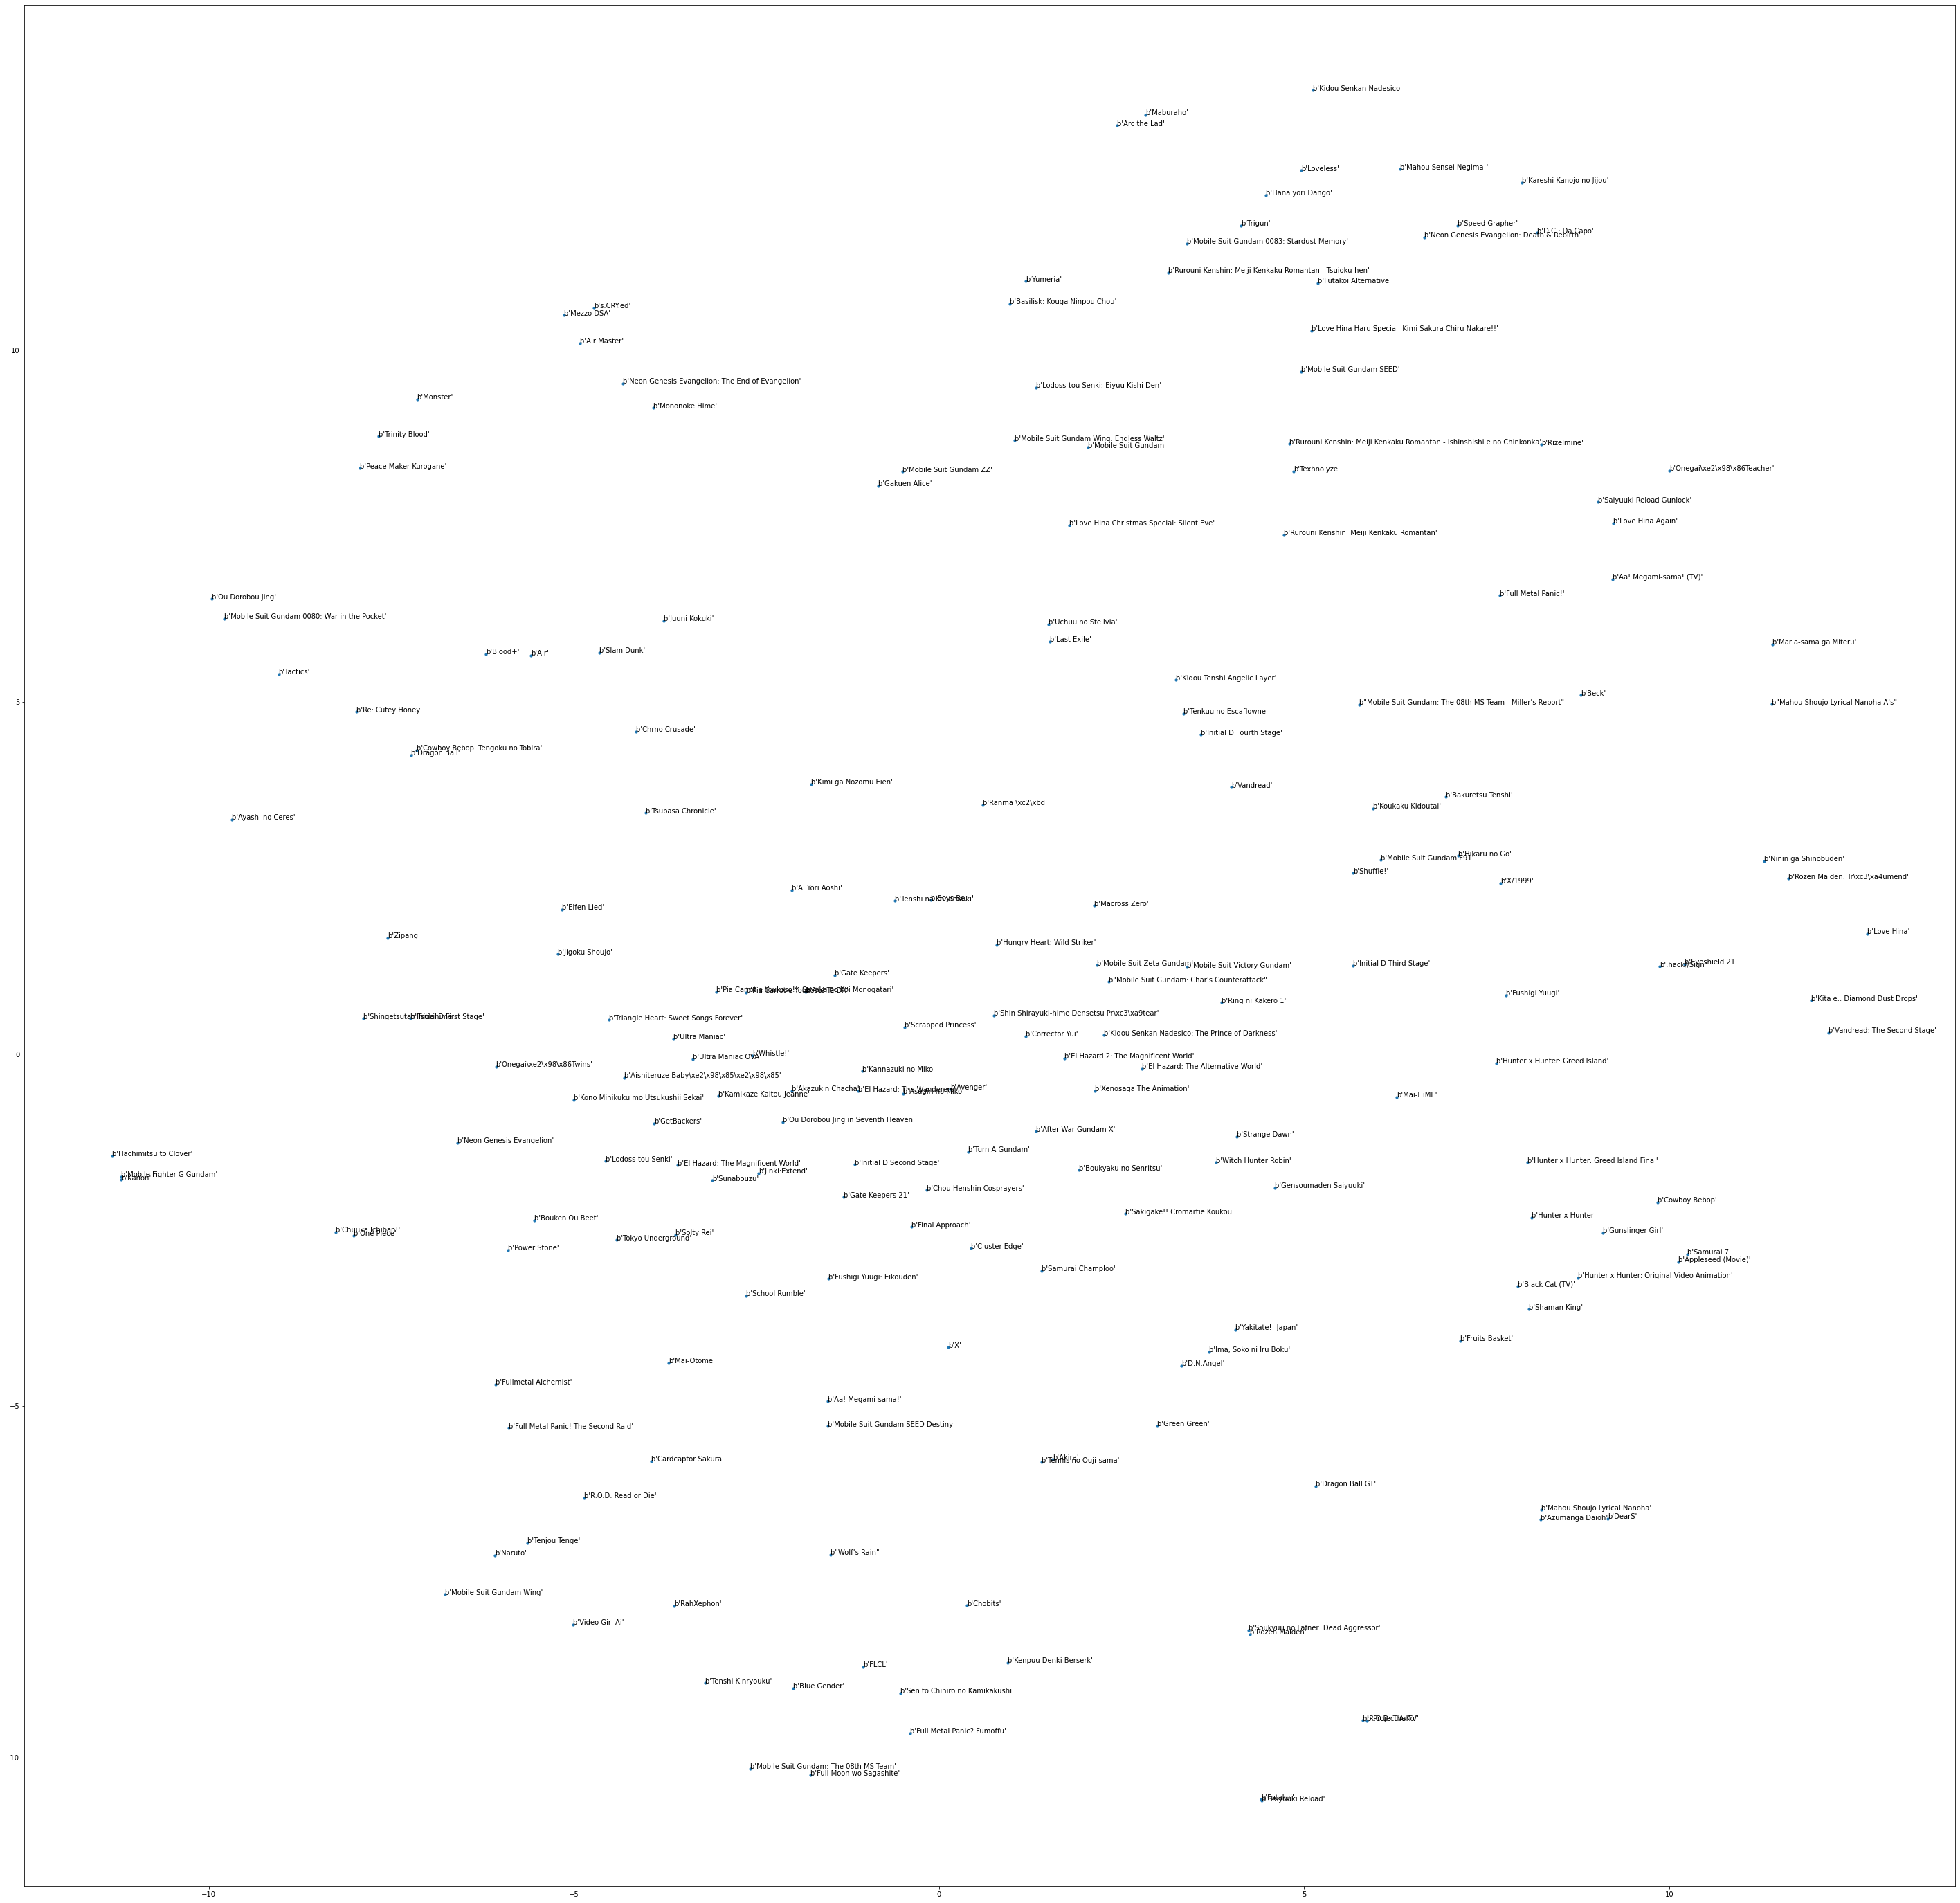

In [194]:
fig, ax = plt.subplots(figsize=(50,50))
ax.scatter(item_tsne[:,0], item_tsne[:,1], s=10)

for i, txt in enumerate(anime_names):
    ax.annotate(txt, (item_tsne[i]))
fig.savefig('embeddings_3.png')